
Fais tes modifs.

git add .

git commit -m "mon message"

git push origin main (ça envoie sur ton GitHub).

puis faire le pull recuest

Et pour récupérer le travail : git pull upstream main.

In [32]:
import numpy as np
from typing import Callable
import matplotlib.pyplot as plt
import time


pi = np.pi
def cos(x: float) ->float:
    return np.cos(x)
def sin(x: float) ->float:
    return np.sin(x)

# Le problème

$-\frac{d}{dx}(D(x)\frac{du}{dx})=f(x)$  $ 

$u(0)=u_0$

$u(1)=u_1$

In [27]:
def D(x:float) -> float:
    return 1 + sin(x)/2

In [28]:
def f(x:float) -> float:
    return pi*cos(x)*sin(2*pi*x)+4*pi*pi*(1 + sin(x)/2)*cos(2*pi*x)

## Les conditions aux limites 

In [34]:
u0 = 1
u1 = 1

## La solution Exact

In [30]:
def u_solution(x: float) -> float :
    return cos(2*pi*x)

# Discrétisation du problème

Posons le problème sous la forme AU = F

In [21]:
def A_constructor(N: int, D: Callable[[float], float]) -> np.ndarray :
    h = 1/N
    A = np.zeros((N-1, N-1), float)
    for i in range(N-1):
        for j in range(N-1):
            if i == j :
                A[i][j] = N*N*(D((i+1/2)*h) + D((i-1/2)*h))
            elif i + 1 == j :
                A[i][j] = -N*N*D((i+1/2)*h)
            elif i - 1 == j :
                A[i][j] = -N*N*D((i-1/2)*h)
            else :
                A[i][j] = 0
    return A


In [20]:
def F_constructor(N: int, f: Callable[[float], float], D: Callable[[float], float], u0: float, u1: float) -> np.ndarray :
    h = 1/N
    F = np.zeros((N-1), float)
    for i in range(N-1):
        F[i] = f((i+1)*h)
        if i == 0 :
            F[i] += N*N*D(1/(2*N))*u0
        elif i == N-2 :
            F[i] += N*N*D(((2*N-1)/(2*N)))*u1
    return F

* Puis on inverse A pour trouver U
* Et on essaye pour differente valeure de N
* Et enfin on trace l'erreur relative a la norme L2 comme fonction de N

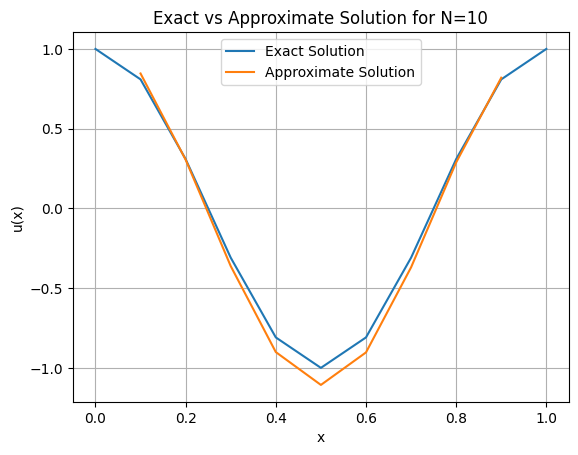

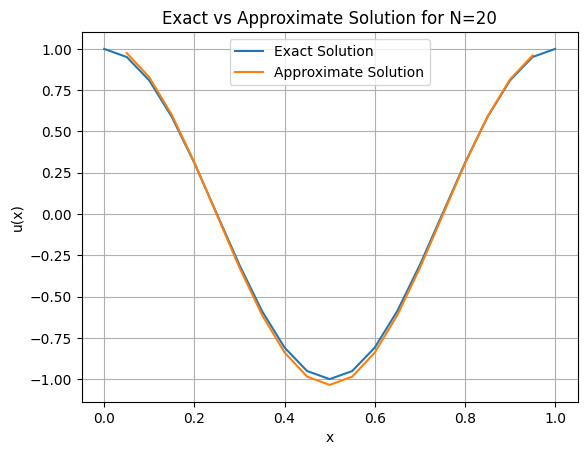

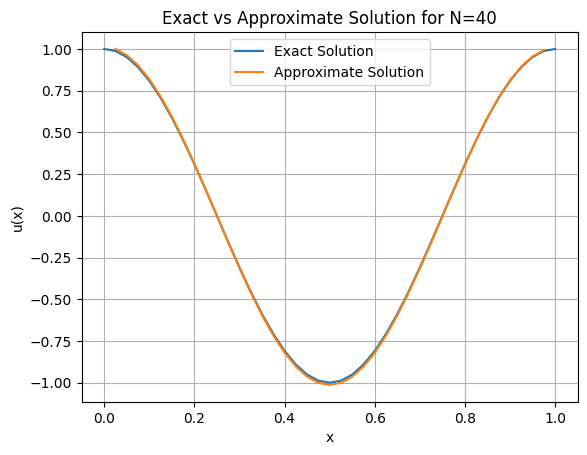

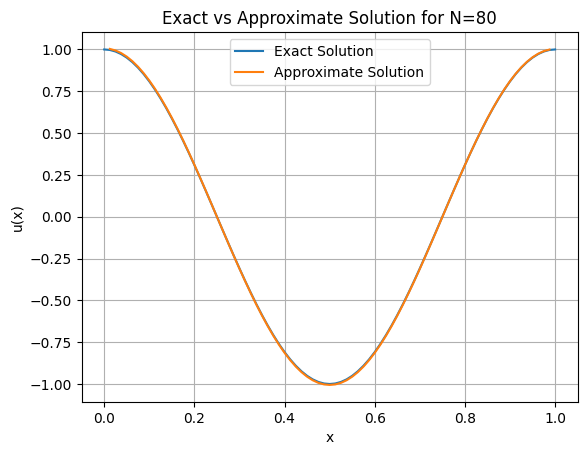

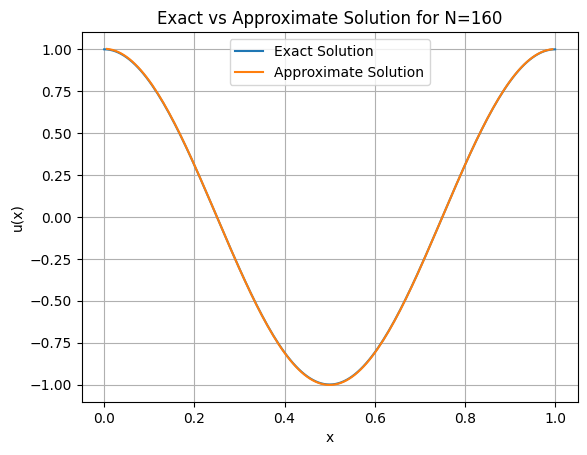

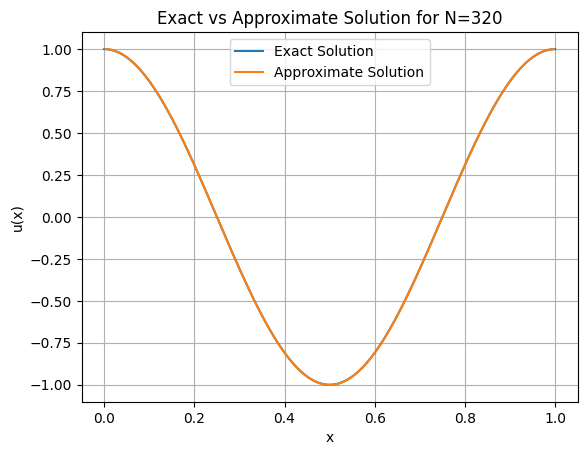

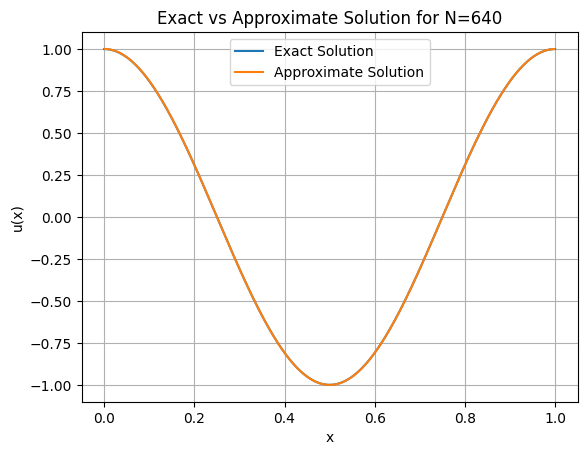

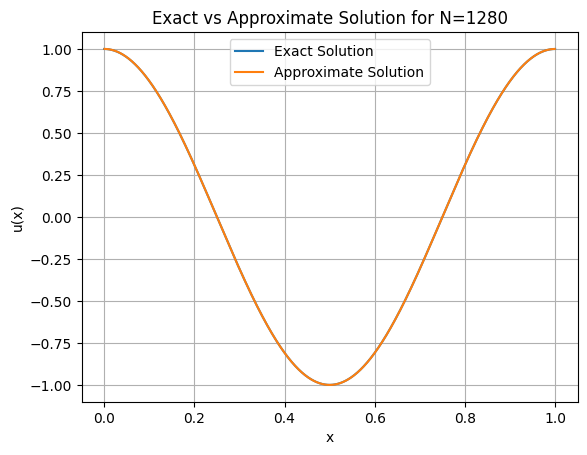

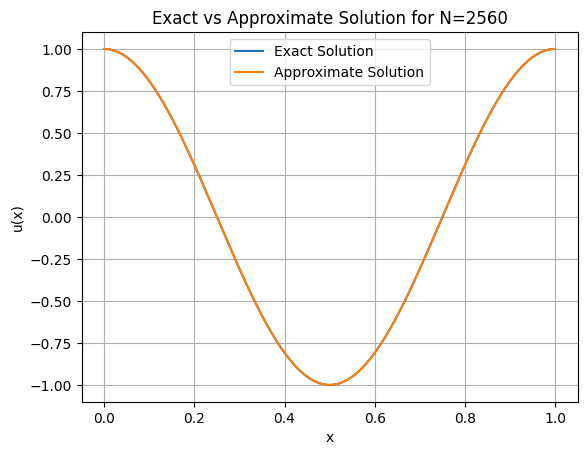

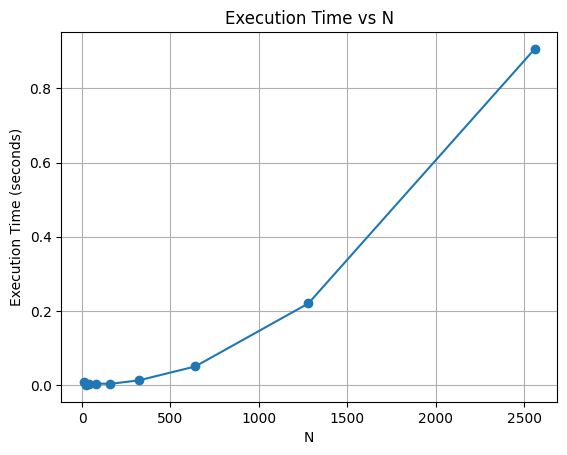

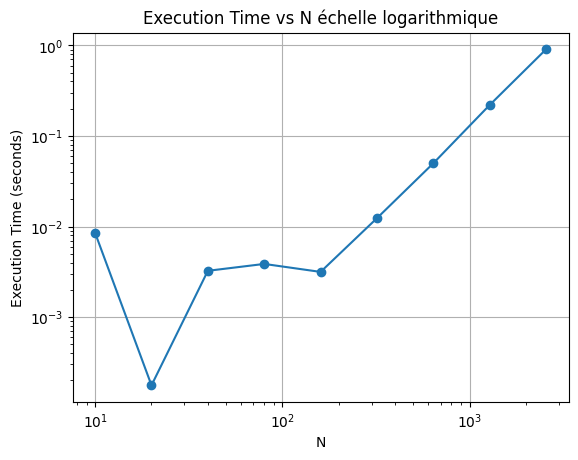

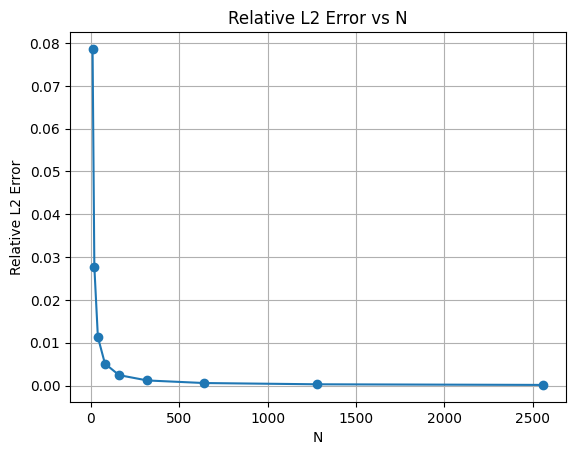

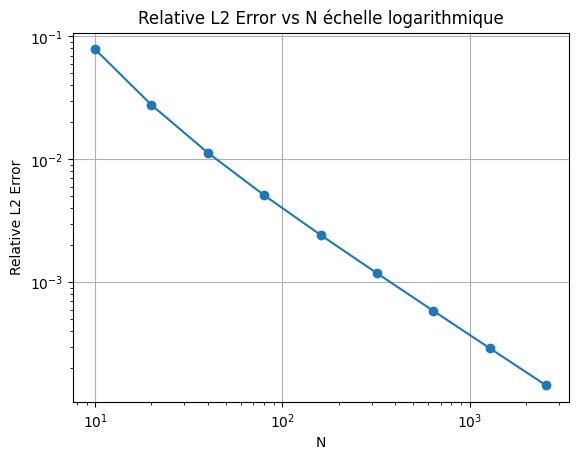

In [41]:
N_values = [10, 20, 40, 80, 160, 320, 640, 1280, 2560]
errors = []
duree = []
for N in N_values:
    start_time = time.time()
    A = np.array(A_constructor(N, D), dtype=float)
    F = np.array(F_constructor(N, f, D, u0, u1), dtype=float)
    u_approx = np.linalg.solve(A, F)
    x_values = [(i)/N for i in range(N+1)]
    u_exact = [u_solution(x) for x in x_values]
    error2 = np.sqrt(sum([(u_approx[i-1] - u_exact[i])**2 for i in range(1, N)]))/np.sqrt(sum([u_exact[i]**2 for i in range(N+1)]))
    errors.append(error2)
    duree.append(time.time() - start_time)
    plt.plot(x_values, u_exact, label='Exact Solution')
    plt.plot(x_values[1:N], u_approx, label='Approximate Solution')
    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.title(f'Exact vs Approximate Solution for N={N}')
    plt.legend()
    plt.grid()
    plt.show()
plt.plot(N_values, duree, marker='o')
plt.xlabel('N')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time vs N')
plt.grid()
plt.show()
plt.loglog(N_values, duree, marker='o')
plt.xlabel('N')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time vs N échelle logarithmique')
plt.grid()
plt.show()
plt.plot(N_values, errors, marker='o')
plt.xlabel('N')
plt.ylabel('Relative L2 Error')
plt.title('Relative L2 Error vs N')
plt.grid()
plt.show()
plt.loglog(N_values, errors, marker='o')
plt.xlabel('N')
plt.ylabel('Relative L2 Error')
plt.title('Relative L2 Error vs N échelle logarithmique')
plt.grid()
plt.show()


# Deuxième cas test (paramétrique)

$D_{\mu}(x)=1+\mu_D$,    $f_{\mu}=\mu_1 sin(\pi x) + \mu_2 sin(2\pi x)$

In [ ]:
muD = 1
mu1 = 1
mu2 = 1